# Training a machine learning classifier on resting state fMRI or structural MRI data

The goal is to train a classifier on MRI data. Two suitable data sets were identified.

## Getting the data

The ABIDE data set can be downloaded using nilearn. The data set contains resting state functional magnetic resonance imaging (rs-fMRI) data from multiple sites. Some of the participants had Autism Spectrum Disorder (ASD). This dataset could be used to train a classifier to distinguish ASD and control participants based on the resting state data.

The data were preprocessed with different pipelines. We will download the data preprocessed with the CPAC pipeline. For more on the differences between pipelines see [here](http://preprocessed-connectomes-project.org/abide/Pipelines.html). I have to be honest that I don't know too much about what exactly the differences are, so this choice was more or less made arbitrarily.

We are setting quality_checked to "True", to only include subjects that passed quality control.

The main analysis will be run on an high performance computing (HPC) cluster hosted by [Compute Canada](https://www.computecanada.ca/). To set up and test the script we will be using a subset of 10 participants.

In [30]:
from nilearn import datasets
#CHANGE PATH (data_dir) TO WERE YOU WANT TO STORE THE DATA
abide = datasets.fetch_abide_pcp(data_dir="/mnt/c/brainhackschool/project/data",
                                n_subjects=50,
                                pipeline="cpac",
                                quality_checked=True,
                                )

/home/mikkel/miniconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Downloaded 110058848 of 110058848 bytes (100.0%,    0.0s remaining) ...done. (28 seconds, 0 min)


Downloaded 110376924 of 110376924 bytes (100.0%,    0.0s remaining) ...done. (45 seconds, 0 min)


Downloaded 102489954 of 102489954 bytes (100.0%,    0.0s remaining) ...done. (22 seconds, 0 min)


Downloaded 108195357 of 108195357 bytes (100.0%,    0.0s remaining) ...done. (37 seconds, 0 min)


Downloaded 105232630 of 105232630 bytes (100.0%,    0.0s remaining) ...done. (24 seconds, 0 min)


Downloaded 111013388 of 111013388 bytes (100.0%,    0.0s remaining) ...done. (25 seconds, 0 min)


Downloaded 104067786 of 104067786 bytes (100.0%,    0.0s remaining) ...done. (27 seconds, 0 min)


Downloaded 107633250 of 107633250 bytes (100.0%,    0.0s remaining) ...done. (21 seconds, 0 min)


Downloaded 106714902 of 106714902 bytes (100.0%,    0.0s remaining) ...done. (20 seconds, 0 min)


Downloaded 112515401 of 112515401 bytes (100.0%,    0.0s remaining) ...done. (26 seconds, 0 min)


Downloaded 111380261 of 111380261 bytes (100.0%,    0.0s remaining) ...done. (26 seconds, 0 min)


Downloaded 109481301 of 109481301 bytes (100.0%,    0.0s remaining) ...done. (32 seconds, 0 min)


Downloaded 118156589 of 118156589 bytes (100.0%,    0.0s remaining) ...done. (39 seconds, 0 min)


Downloaded 101609576 of 101609576 bytes (100.0%,    0.0s remaining) ...done. (27 seconds, 0 min)


Downloaded 114979022 of 114979022 bytes (100.0%,    0.0s remaining) ...done. (25 seconds, 0 min)


Downloaded 108536527 of 108536527 bytes (100.0%,    0.0s remaining) ...done. (27 seconds, 0 min)


Downloaded 100315008 of 100315008 bytes (100.0%,    0.0s remaining) ...done. (26 seconds, 0 min)


Downloaded 112518259 of 112518259 bytes (100.0%,    0.0s remaining) ...done. (24 seconds, 0 min)


Downloaded 105071443 of 105071443 bytes (100.0%,    0.0s remaining) ...done. (26 seconds, 0 min)


Downloaded 108382438 of 108382438 bytes (100.0%,    0.0s remaining) ...done. (32 seconds, 0 min)


Downloaded 105424334 of 105424334 bytes (100.0%,    0.0s remaining) ...done. (24 seconds, 0 min)


Downloaded 107697423 of 107697423 bytes (100.0%,    0.0s remaining) ...done. (21 seconds, 0 min)


Downloaded 102831611 of 102831611 bytes (100.0%,    0.0s remaining) ...done. (19 seconds, 0 min)


Downloaded 105868787 of 105868787 bytes (100.0%,    0.0s remaining) ...done. (23 seconds, 0 min)


Downloaded 110373167 of 110373167 bytes (100.0%,    0.0s remaining) ...done. (22 seconds, 0 min)


Downloaded 106676912 of 106676912 bytes (100.0%,    0.0s remaining) ...done. (30 seconds, 0 min)


Downloaded 95467541 of 95467541 bytes (100.0%,    0.0s remaining) ...done. (20 seconds, 0 min)


Downloaded 107811709 of 107811709 bytes (100.0%,    0.0s remaining) ...done. (23 seconds, 0 min)


Downloaded 103013827 of 103013827 bytes (100.0%,    0.0s remaining) ...done. (21 seconds, 0 min)


Downloaded 109340774 of 109340774 bytes (100.0%,    0.0s remaining) ...done. (25 seconds, 0 min)


Downloaded 110403873 of 110403873 bytes (100.0%,    0.0s remaining) ...done. (22 seconds, 0 min)


Downloaded 102741119 of 102741119 bytes (100.0%,    0.0s remaining) ...done. (23 seconds, 0 min)


Downloaded 113831652 of 113831652 bytes (100.0%,    0.0s remaining) ...done. (33 seconds, 0 min)


Downloaded 102054140 of 102054140 bytes (100.0%,    0.0s remaining) ...done. (20 seconds, 0 min)


Downloaded 109775490 of 109775490 bytes (100.0%,    0.0s remaining) ...done. (22 seconds, 0 min)


Downloaded 119693152 of 119693152 bytes (100.0%,    0.0s remaining) ...done. (25 seconds, 0 min)


Downloaded 114295718 of 114295718 bytes (100.0%,    0.0s remaining) ...done. (24 seconds, 0 min)


Downloaded 115673440 of 115673440 bytes (100.0%,    0.0s remaining) ...done. (34 seconds, 0 min)


Downloaded 109552949 of 109552949 bytes (100.0%,    0.0s remaining) ...done. (27 seconds, 0 min)


Downloaded 105507823 of 105507823 bytes (100.0%,    0.0s remaining) ...done. (29 seconds, 0 min)


## Extracting the functional connectivity data

As basis for training the classifier we will use the functional connectivity matrix. This will closely resemble the approach taken in [the machine learning intro](https://github.com/neurodatascience/course-materials-2020/tree/master/lectures/14-may/03-intro-to-machine-learning) of the Brainhackschool 2020 held by Jake Vogel.

Our data set now contains 10 subjects.

In [31]:
len(abide.func_preproc)

50

We need to decide which parcellation to use. For the sake of simplicity, let us take the same one as in the tutorial, as that one seems suitable for rs-fMRI data. This would be the MIST atlas [(Urchs et al. 2019)](https://mniopenresearch.org/articles/1-3).

In [32]:
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

This is what the atlas looks like:

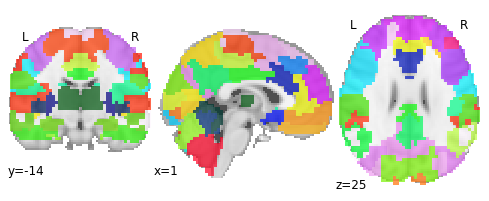

In [33]:
from nilearn import plotting

plotting.plot_roi(atlas_filename, draw_cross=False)

We'll store the filenames of the functional scans in a list that we can later loop over. To test the functions, we will only use the first image in our data set.

In [34]:
fmri_filenames = abide.func_preproc[0]
fmri_filenames

'/mnt/c/brainhackschool/project/data/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050003_func_preproc.nii.gz'

Using NiftiLabelsMasker we will create a mask on our functional images with the labels of the chosen atlas and extract the time series in each ROI. Because the data is already preprocessed, we do not need to regress out any confounds.

In [35]:
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                           standardize=True, 
                           memory='nilearn_cache', 
                           verbose=1)

time_series = masker.fit_transform(fmri_filenames)

[NiftiLabelsMasker.fit_transform] loading data from /home/mikkel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels


The correlation matrix of the ROIs is computed.

In [36]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

(64, 64)

...and plotted

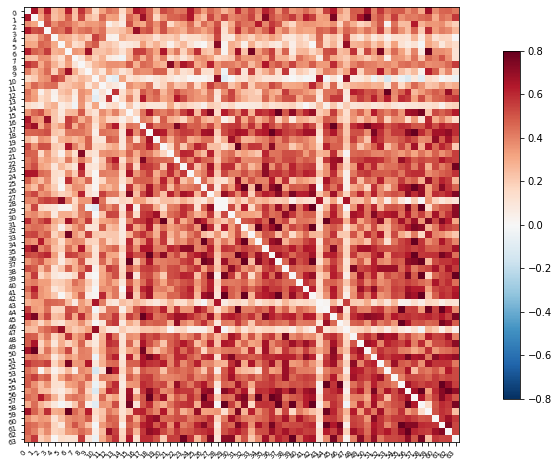

In [37]:
import numpy as np

np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

All right, this seems to work! Now let's combine this in a for loop.

In [38]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# make list of filenames
fmri_filenames = abide.func_preproc

# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

# initialize masker object
masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                           standardize=True, 
                           memory='nilearn_cache', 
                           verbose=0)

# initialize correlation measure
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

all_features = [] # here is where we will put the data (a container)

#for i,sub in enumerate(fmri_filenames):
#    # extract the timeseries from the ROIs in the atlas
#    time_series = masker.fit_transform(sub)
#    # create a region x region correlation matrix
#    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
#    # add to our container
#    all_features.append(correlation_matrix)
#    # keep track of status
#    print('finished %s of %s'%(i+1,len(fmri_filenames)))

finished 1 of 50
finished 2 of 50
finished 3 of 50
finished 4 of 50
finished 5 of 50
finished 6 of 50
finished 7 of 50
finished 8 of 50
finished 9 of 50
finished 10 of 50
finished 11 of 50
finished 12 of 50
finished 13 of 50
finished 14 of 50
finished 15 of 50
finished 16 of 50
finished 17 of 50
finished 18 of 50
finished 19 of 50
finished 20 of 50
finished 21 of 50
finished 22 of 50
finished 23 of 50
finished 24 of 50
finished 25 of 50
finished 26 of 50
finished 27 of 50
finished 28 of 50
finished 29 of 50
finished 30 of 50
finished 31 of 50
finished 32 of 50
finished 33 of 50
finished 34 of 50
finished 35 of 50
finished 36 of 50
finished 37 of 50
finished 38 of 50
finished 39 of 50
finished 40 of 50
finished 41 of 50
finished 42 of 50
finished 43 of 50
finished 44 of 50
finished 45 of 50
finished 46 of 50
finished 47 of 50
finished 48 of 50
finished 49 of 50
finished 50 of 50


Let us save this data to our data directory.

In [39]:
import numpy as np

#np.savez_compressed('/mnt/c/brainhackschool/project/data/ABIDE_BASC064_subsamp_features',a = all_features)

We can load them again like this:

In [40]:
feat_file = '/mnt/c/brainhackschool/project/data/ABIDE_BASC064_subsamp_features.npz'
X_features = np.load(feat_file)['a']

X_features.shape

(50, 2016)

## Get target variable Y

Accompanying the data set is a csv file containing the phenotypic data. According to the Phenotypic Data Legend which can be downloaded [here](http://fcon_1000.projects.nitrc.org/indi/abide/abide_I.html), the column DX_GROUP has the information about the diagnostic group each participant is in. It is coded as:

- 1 = Autism
- 2 = Control

Let's import the csv.

In [41]:
import pandas as pd
phenotypic = pd.read_csv("/mnt/c/brainhackschool/project/data/ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv")

We'll use the file names to get the right values from the DX_GROUP column.

In [42]:
file_ids = []
# get the file IDs from the file names
# CAUTION, WILL PROBABLY ONLY WORK FOR PITT SUBJECTS!
for f in fmri_filenames:
    file_ids.append(f[-32:-20])

y_asd = []
for i in range(len(phenotypic)):
    if phenotypic.FILE_ID[i] in file_ids:
        y_asd.append(phenotypic.DX_GROUP[i])

## Prepare the data for machine learning

For our test run we will divide our data set into a training and a test set.

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, # x
                                                  y_asd, # y
                                                  test_size = 0.4, # 60%/40% split  
                                                  shuffle = True, # shuffle dataset before splitting
                                                  stratify = y_asd,  # keep distribution of ASD consistent between sets
                                                  random_state = 123 # same shuffle each time
                                                 )

We visualize the distributions:

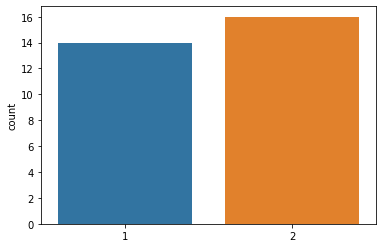

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x = y_train, label = "train")
sns.countplot(x = y_val, label = "test")